# Tutorial for pre-processing in the Toxic Comment challenge

In [1]:
import matplotlib.pyplot as plt
from collections import Counter

from tools import *

Using TensorFlow backend.


## Loading data

In [2]:
data_train, y_train, data_test, id_test = load_data()

## Encoding data

In [3]:
# -------
### CBOW

# Create a CBOW vectorizer for english words, without accent,
## limiting the vocabulary to 30000 words max.

count_vectorizer = CountVectorizer(analyzer='word', stop_words='english',
                                   strip_accents='unicode', max_features=30000)

# -------
### Hash

# Create a CBOW vectorizer for english words, without accent. No limit on vocab size

hash_vectorizer = HashingVectorizer(analyzer='word', stop_words='english',
                                     strip_accents='unicode')


# --------
### TFIDF

# Create a TFIDF vectorizer for english words, (only unigrams), limiting the vocabulary to
# 30000 words max.and filtering words with frequency under 10.
## Remove accents, and using idf for filtering, with smoothing to avoid zero division

tfidf_vectorizer = TfidfVectorizer(stop_words='english', analyzer='word', ngram_range=(1,1),
                                   min_df=10, max_features=30000,
                                   strip_accents='unicode', use_idf=1,smooth_idf=1,
                                   sublinear_tf=1)

# ------------
### Tokenizer

## Tokenize the corpus, with only the 30000 most commons tokens, and pad the sentences to 200
tokens_vectorizer = TokenVectorizer(max_len=200, max_features=30000)



In [4]:
X_train, X_test = encode(data_train, data_test, vectorizer=count_vectorizer)

# Vocabulary can be extracted from the vectorizer object (if tdidf or count)
# print(count_vectorizer.get_feature_names())

ENCODING: Fitting vectorizer to data
ENCODING: transforming data to numerical


## Submitting data to .csv

In [5]:
# Toy prediction to test submission
y_test = np.ones((len(data_test), y_train.shape[1]))

submission(y_train, id_test, name='')

## Visualising the labels distribution of dataset

In [6]:
y_train_binary = np.atleast_2d(np.sum(y_train, axis=1)).T
y_train_binary[y_train_binary>0] = 1
y_train_with_clean = np.concatenate((y_train_binary, y_train), axis=1)

print(y_train_with_clean.shape)
print(np.sum(y_train_binary))

(159571, 7)
16225


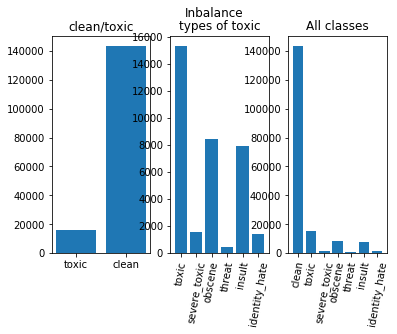

In [7]:
plt.figure()
plt.tight_layout()
plt.suptitle('Imbalance')
plt.subplot(1, 3, 1)

plt.title('clean/toxic')
plt.bar(['toxic', 'clean'], [np.sum(y_train_binary), y_train_binary.shape[0]- np.sum(y_train_binary)])

plt.subplot(1, 3, 2)

plt.title('types of toxic')
plt.bar(CLASSES, np.sum(y_train_with_clean[y_train_with_clean[:,0]==1, 1:], axis=0))

plt.xticks(rotation=80)

plt.subplot(1, 3, 3)

plt.title('All classes')
plt.bar(['clean'] + CLASSES, [y_train_binary.shape[0]- np.sum(y_train_binary)] +\
                             list(np.sum(y_train_with_clean[y_train_with_clean[:,0]==1, 1:], axis=0)))
plt.xticks(rotation=80)

plt.show()

<BarContainer object of 6 artists>

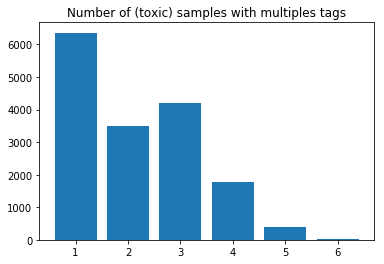

In [8]:
# Look for multi tags samples
count_multi_tags = Counter(np.sum(y_train, axis=1))

len(count_multi_tags)

plt.figure()
plt.title('Number of (toxic) samples with multiples tags')

plt.bar(list(count_multi_tags.keys())[1:], list(count_multi_tags.values())[1:])

In [ ]:
# corr_matrix = np.corrcoef(y_train_with_clean[:, y_train])

## Inspecting comments

In [12]:
for idx, (comment, label) in enumerate(zip(data_train, y_train)):
    
    if idx > 200:
        break
        
    if np.sum(label) == 0:
        continue
        
    print(label)
    print(comment)
    print('-------')

[1 1 1 0 1 0]
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
-------
[1 0 0 0 0 0]
Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...
-------
[1 0 0 0 0 0]
Bye! 

Don't look, come or think of comming back! Tosser.
-------
[1 0 1 0 1 1]
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warni

## Comments cleaning

In [13]:
params = {'lower': True, 
          'lemma': True, 
          'stop_words': True}

comment = data_train[2]
print(comment)
print('-------')
print(CommentCleaner(**params).transform(comment))

Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
-------
hey man really try edit war guy constantly remove relevant information talk edit instead talk page seem care format actual info


In [14]:
clean_data_train = transform_dataset(data_train, transformer=CommentCleaner, kwargs=params)
clean_data_test = transform_dataset(data_test, transformer=CommentCleaner, kwargs=params)

Transformation: 100%       
Transformation: 100%       


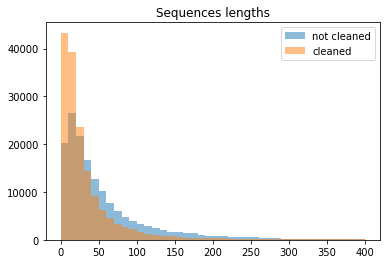

In [15]:
# how to set SENTENCE_LENGTH ?
seq_lengths = [len(comment.split()) for comment in data_train]
cleaned_seq_lengths = [len(comment.split()) for comment in clean_data_train]
hist_bins = np.arange(0, 410, 10)

plt.hist(seq_lengths, bins=hist_bins, alpha=0.5, label='not cleaned')
plt.hist(cleaned_seq_lengths, bins=hist_bins, alpha=0.5, label='cleaned')
# plt.hist([seq_lengths, cleaned_seq_lengths], bins=hist_bins, label=['not cleaned', 'cleaned'])
plt.legend(loc='upper right')
plt.title("Sequences lengths")
plt.show()

## Auxiliary features

In [8]:
print("Computing comments length")
comments_lengths = np.array(transform_dataset(data_train, transformer=CommentLength, n_prints=5))

print("Computing number of punctuation marks in comments")
params = {'divide_by_len': True, 'chars_set': {'!'}}
comments_punctuation = np.array(transform_dataset(data_train, transformer=CharCounter, kwargs=params))

print("Computing number of upper cased words in comments")
params = {'divide_by_len': True}
comments_upperwords = np.array(transform_dataset(data_train, transformer=UppercaseWordsCounter, kwargs=params))

Computing comments length
Transformation: 100%       
Computing punctuation marks in comments
Transformation: 100%       
Computing number of upper cased words in comments
Transformation: 100%       


In [9]:
lengths = [comments_lengths[np.sum(y_train, axis=1) == 0], comments_lengths[np.sum(y_train, axis=1) > 0]]
punctuation = [comments_punctuation[np.sum(y_train, axis=1) == 0], comments_punctuation[np.sum(y_train, axis=1) > 0]]
upperwords = [comments_upperwords[np.sum(y_train, axis=1) == 0], comments_upperwords[np.sum(y_train, axis=1) > 0]]

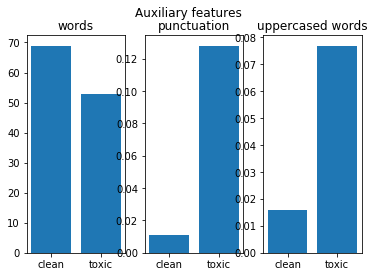

In [12]:
plt.figure()
plt.suptitle('Auxiliary features')

plt.subplot(1, 3, 1)
plt.title('words')
plt.bar(['clean', 'toxic'], [np.mean(lengths[0]), np.mean(lengths[1])])

plt.subplot(1, 3, 2)
plt.title('punctuation')
plt.bar(['clean', 'toxic'], [np.mean(punctuation[0]), np.mean(punctuation[1])])

plt.subplot(1, 3, 3)
plt.title('uppercased words')
plt.bar(['clean', 'toxic'], [np.mean(upperwords[0]), np.mean(upperwords[1])])

plt.show()